# Tutorial: applying excursion in 1 dimension

## (with GPyTorch)

In [1]:
#generic imports
import numpy as np
import datetime
import os
import json
import yaml
import math
import time
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline
np.warnings.filterwarnings('ignore')

#excursion package imports
import excursion
%load_ext autoreload
%autoreload 2

## Step 0: What is excursion?
You can find an explanation [here]()
#TO DO
Also, it is advisable to use a virtualenv with the following [requeriments](https://github.com/irinaespejo/excursion/blob/master/requeriments.txt)

## Step 1: Load

We need to initilize several things and with a specific structure so that it's readable:

-  **True/Black-box function** (this is not a tutorial using funcX, just a simple toy function is all we need) 
-  **Grid**: where do you want to search for next evaluation points?
-  **Gaussian Process**: which kernel and likelihood do you want to use?
-  **Algorithm Options**: which acquisition function? Do you want batch selection? How many points per batch? Which batch method selection?

There are many choices and a user might not know a priori what to use. That is why we have prepared a set of complete examples that you just have to load to get started. These pre-build examples are in `excursion/testcases/fast_1D.py`these `.py` scripts contain initialization for: true/black-box function and grid (the "numerical options"). The files in `excursion/testcases/algorithms/algorithm_specs.yml` are yaml files that contain prestablished Gaussian Processes and Algorithm Options (the "algorithm options"). This way of ordering the init step makes it easy to fix a numerical problem while trying different algorithm configurations and vice versa.

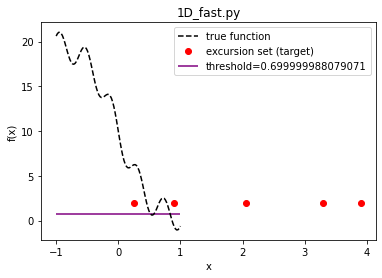

In [2]:
#load testcase
import testing.testcases.fast_1D as testcase_details

#plot function and thresholds
for func in testcase_details.true_functions:
    X_plot = testcase_details.plot_X
    true = plt.plot(X_plot, func(X_plot), label='true function', color='black', linestyle='--')
    
for thr in testcase_details.thresholds:
    min_X = torch.min(testcase_details.plot_X)
    max_X = torch.max(testcase_details.plot_X)
    t = plt.hlines(thr, min_X, max_X, colors = 'purple', label='threshold='+str(thr.item()))

#approximate level set for plot purposes
plt.plot([0.25, 0.89,2.05,3.3,3.9], [2,2,2,2,2], 'ro', label='excursion set (target)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('1D_fast.py')
plt.legend(loc=0)
plt.show()

In [3]:
#load algorithm options
file = open('../testing/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)
print('algorithm_opts =')
print(json.dumps(algorithm_opts, indent=4))

algorithm_opts =
{
    "example": "1Dtoyanalysis",
    "ninit": 2,
    "nupdates": 9,
    "init_type": "random",
    "likelihood": {
        "type": "GaussianLikelihood",
        "epsilon": 0.0
    },
    "model": {
        "type": "ExactGP",
        "kernel": "RBF",
        "prior": "Constant"
    },
    "acq": {
        "acq_type": "MES",
        "batch": false,
        "batchtype": "KB",
        "batchsize": 2
    }
}


## Step 2: Init the Gaussian Proces

We initialize the gaussian process and likelihood according to `algorithm_opts['init_type']`

In [4]:
#is there GPU?
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cpu')
from excursion import init_gp
model, likelihood = init_gp(testcase_details, \
                            algorithm_opts, \
                            algorithm_opts["ninit"], \
                            device)

# X_init and y_init are random points so that we can fit the GP posterior wrt these points

In [5]:
# fit hyperparameters
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

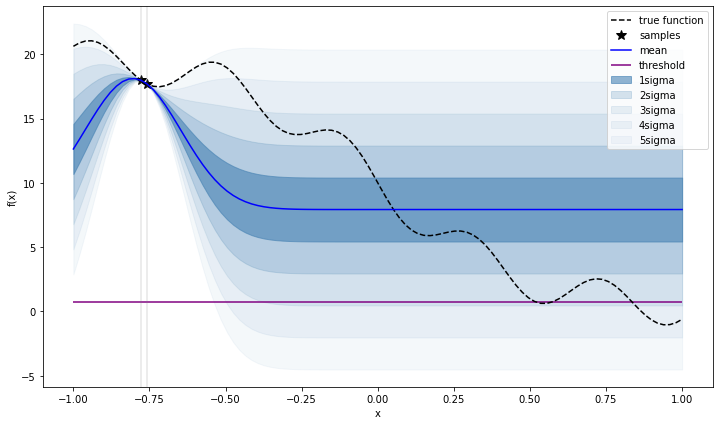

In [6]:
# plot the fitting
import excursion.plotting.onedim as plots
plots.plot_GP(model, testcase_details, device=device)

## Step 3: Init the ExcursionEstimator

In [7]:
from excursion.estimator import ExcursionSetEstimator
# this object keeps internal track of the status of all objects involved
# in excursion at each step
estimator = ExcursionSetEstimator(testcase_details, \
                                  algorithm_opts, \
                                  model, \
                                  likelihood, \
                                  device)

## Step 4:  Smart grid search (active learning)

Iteration  1
I didnt get an axis
Iteration  2
I didnt get an axis
Iteration  3
I didnt get an axis
Iteration  4
I didnt get an axis
Iteration  5
I didnt get an axis
Iteration  6
I didnt get an axis
Iteration  7
I didnt get an axis
Iteration  8
I didnt get an axis
Iteration  9
I didnt get an axis
Iteration  10
I didnt get an axis


<Figure size 432x288 with 0 Axes>

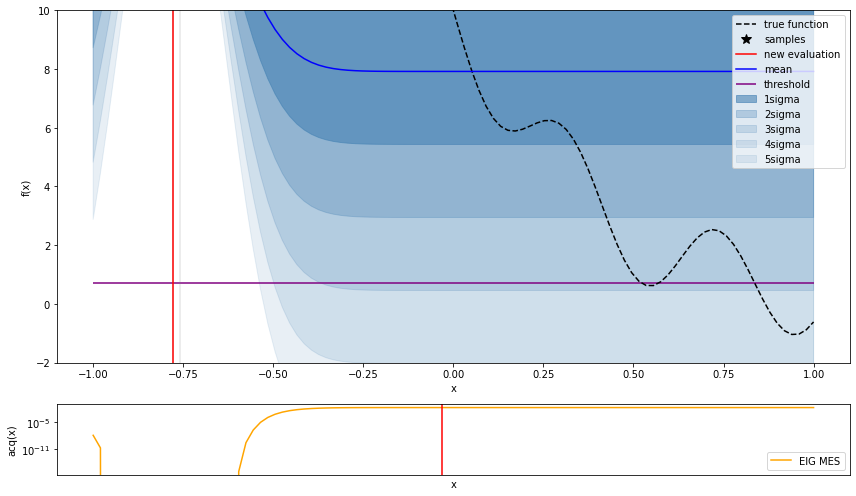

<Figure size 432x288 with 0 Axes>

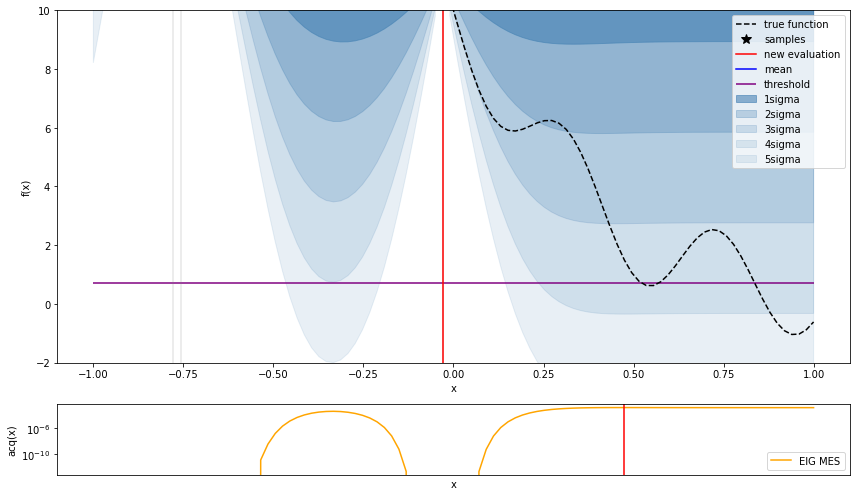

<Figure size 432x288 with 0 Axes>

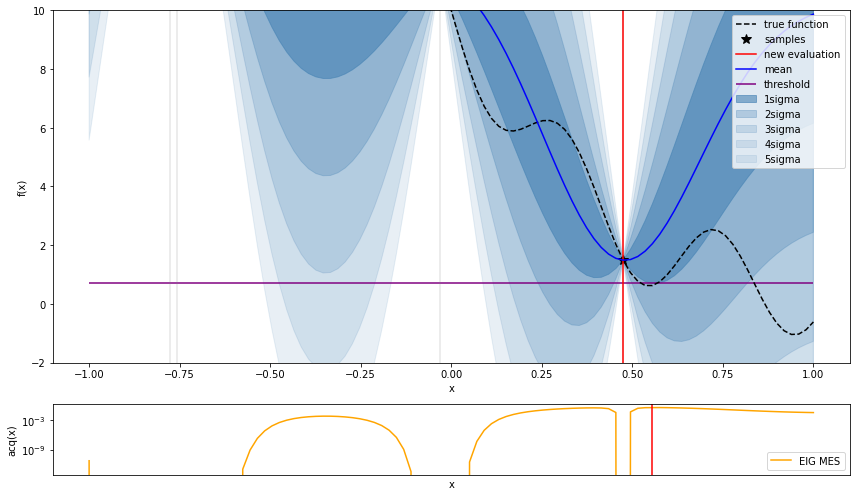

<Figure size 432x288 with 0 Axes>

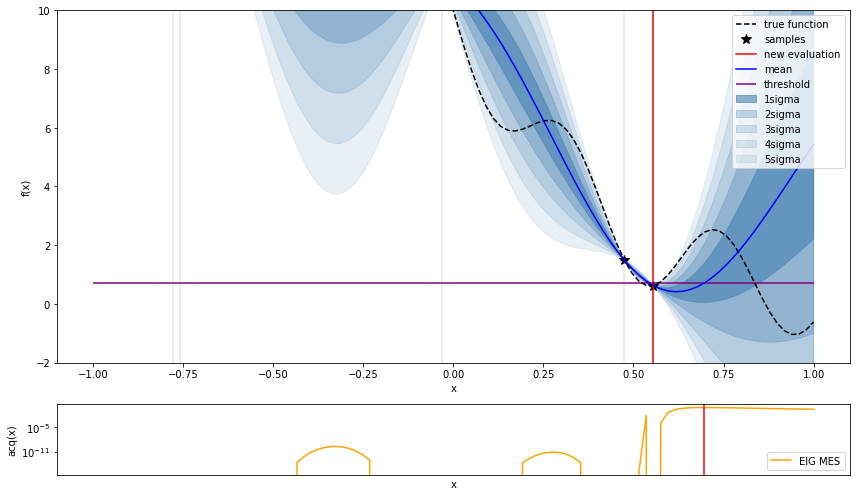

<Figure size 432x288 with 0 Axes>

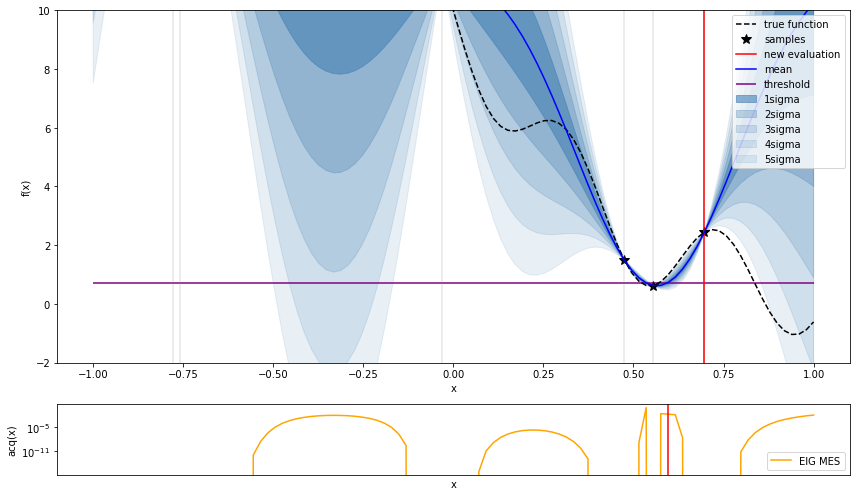

<Figure size 432x288 with 0 Axes>

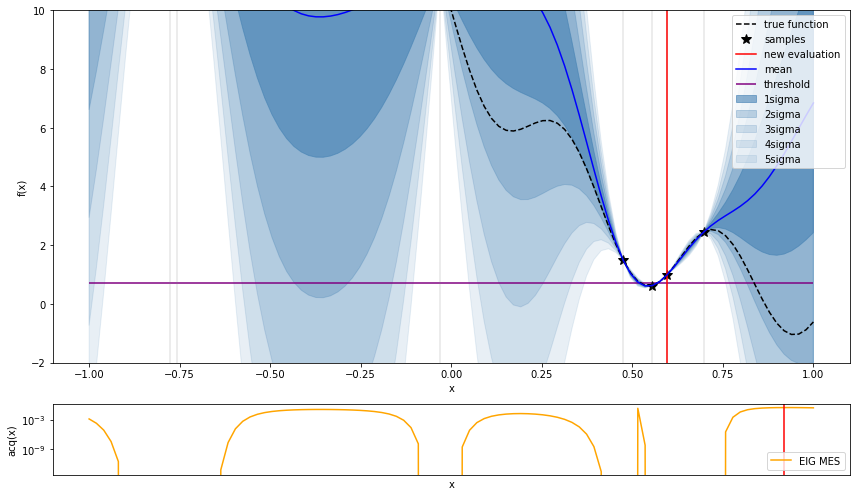

<Figure size 432x288 with 0 Axes>

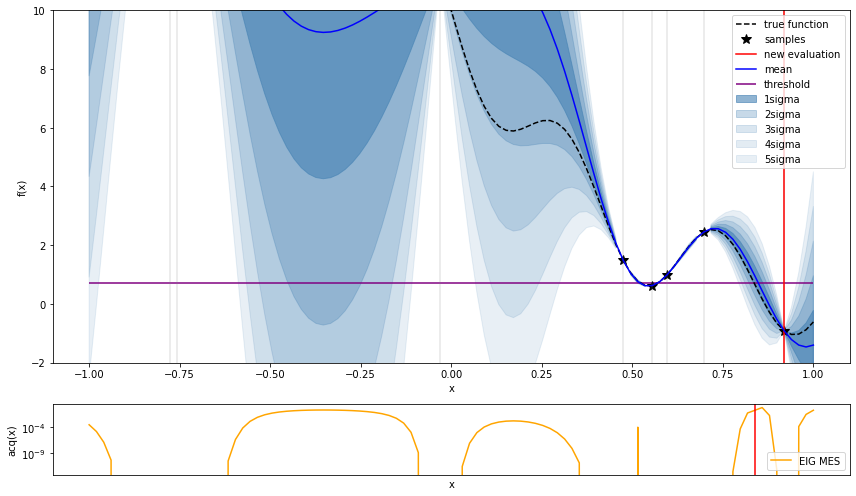

<Figure size 432x288 with 0 Axes>

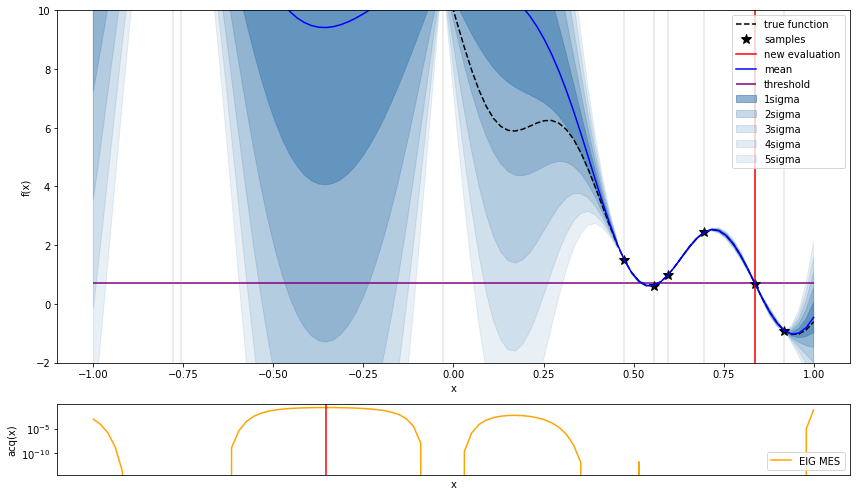

<Figure size 432x288 with 0 Axes>

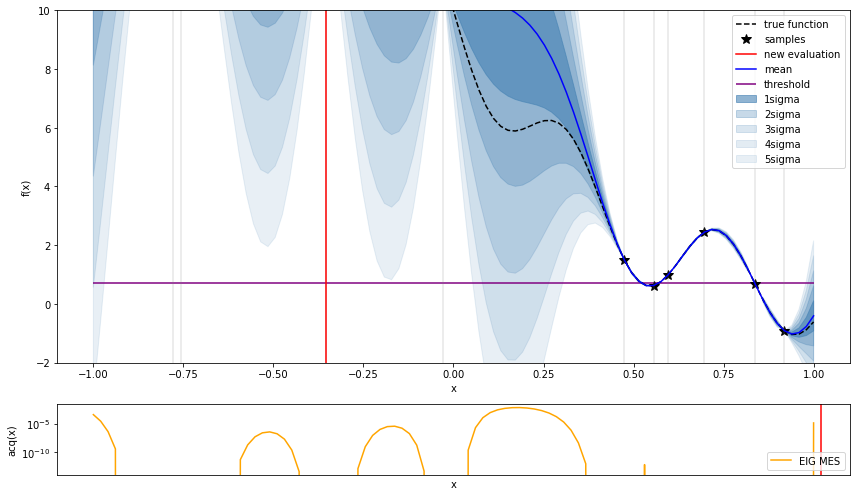

<Figure size 432x288 with 0 Axes>

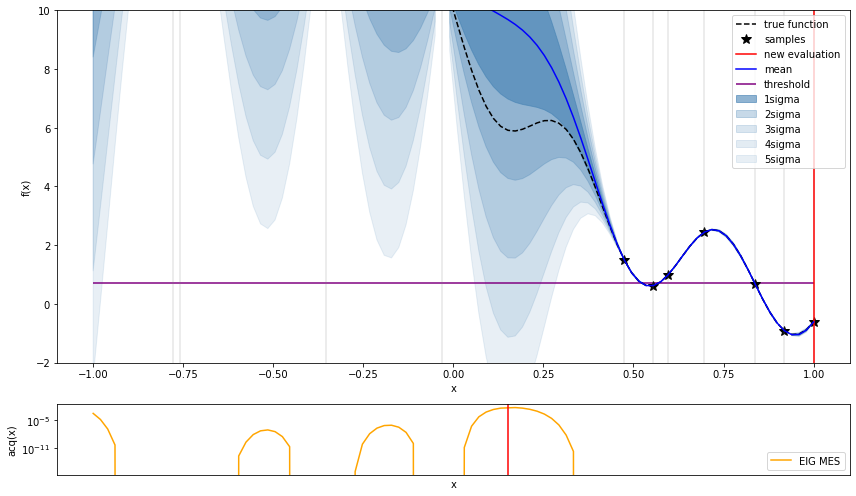

In [8]:
start_time = time.process_time()


n_updates = algorithm_opts['nupdates']
#save results in folder
timestampStr = datetime.datetime.now().strftime('%d-%b-%Y_%H_%M_%S') + '\\'
outputfolder = r'C:\Users\excursion\Documents\excursion_project\excursion\examples\results'
outputfolder = os.path.join(outputfolder, timestampStr)
os.makedirs(outputfolder)

for iteration in range(0, n_updates+1):
    #take a step forward: find new points to evaluate
    estimator.step(testcase_details, algorithm_opts, model, likelihood)


    #plot the new status
    estimator.plot_status(
            testcase_details, algorithm_opts, model, outputfolder)
    
    #update the posterior of the GP wrt the new points
    model = estimator.update_posterior(testcase_details, algorithm_opts, model, likelihood)
    #get diagnostics (accuracy metric)
    # estimator.get_diagnostics(testcase_details, model, likelihood)
    #
#save results
end_time = time.process_time() - start_time

# estimator.print_results(outputfolder, testcase_details, algorithm_opts)

In [9]:

print(end_time)

21.234375
